### English

<hr>

1. Define assets, initial cash, weight per asset, benchmark, download starting date and live portfolio start date.
2. We download the values.
3. We assign the initial investment and weight per asset
4. We prepare the initial shares per asset depending on the assigned weight
5. We perform the rebalancing engine (daily, monthly or yearly) read in the intro.
6. We calculate the metrics and values ​​of the portfolio and variation in weights
7. We visualize
8. We carry out the study in pyfolio for the strategy. We need to localize timezones for this example.


In [18]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [19]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','BA','CAT','XOM','CVX','RIO','BHP'] # Assets to select yfinance format
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)         # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'                # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'


# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [20]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date,end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  15 of 15 completed


In [21]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2009-01-02      24233.0       4415.0      33369.0      1696.0      2640.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2009-01-02      3047.0      978.0      24527.0      3236.0     1964.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2009-01-02      2133.0      1409.0      1556.0      7397.0      2896.0

### 2. Rebalancing Engine

Loop through the data: To check if it's a rebalancing day.
+ If it's the first day, we simply store the initial values.
+ If it's not a rebalancing day, we use the previous values.
+ If it's a rebalancing day (i.e. the year has changed), we calculate new shares based on the new portfolio value and weights, and store the new values as previous values.

Calculate asset values and portfolio value: For each day:
+ We calculate the asset values and portfolio value using the number of shares held for each asset and the asset price.
+ We also store the signal (whether it's a rebalancing day or not) and the portfolio value in the stock data frame.
+ We add the number of shares held for each asset and the asset value to the stock data frame for further analysis.

## monthly rebalance

In [22]:
# set initial shares on the first day
shares_df.loc[stock_data.index[0], :] = [np.floor((portfolio_value * w) / stock_data[s][0]) for s,w in zip(stocks, weights)]

# initialize variables
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month:
        signal = True
        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        balance_month = day.month
        count += 1
        # print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days ;)
        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]
        
        # print(f'Not rebalance, regular day: {day.date()}') # uncomment to debug days ;)



    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [23]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))



In [24]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [25]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [26]:
stock_data.filter(regex='weight')

AAPL_weight  MSFT_weight  NVDA_weight  JNJ_weight  NVS_weight  \
Date                                                                        
2009-01-05     0.069446     0.067245     0.067859    0.065963    0.065868   
2009-01-06     0.066866     0.066602     0.068680    0.064190    0.063457   
2009-01-07     0.068256     0.065305     0.067359    0.066343    0.066894   
2009-01-08     0.069238     0.067070     0.065370    0.065948    0.067878   
2009-01-09     0.069610     0.066951     0.063497    0.067889    0.067785   
...                 ...          ...          ...         ...         ...   
2015-12-18     0.064128     0.069560     0.069654    0.070673    0.069998   
2015-12-21     0.064519     0.070029     0.070866    0.069987    0.069497   
2015-12-22     0.063855     0.070031     0.070266    0.070103    0.068984   
2015-12-23     0.063457     0.069294     0.069213    0.069303    0.069111   
2015-12-24     0.063314     0.069322     0.069659    0.069672    0.069189   

            JPM_weight  GS_weight  AMZN_weight  DIS_weight  BA_weight  \
Date                                                                    
2009-01-05    0.062168   0.068181     0.066265    0.065453   0.067984   
2009-01-06    0.062172   0.066695     0.068833    0.066286   0.066757   
2009-01-07    0.060981   0.066283     0.070364    0.065944   0.067319   
2009-01-08    0.058850   0.066722     0.071272    0.064880   0.067087   
2009-01-09    0.057770   0.067453     0.071216    0.065036   0.068503   
...                ...        ...          ...         ...        ...   
2015-12-18    0.067602   0.064458     0.069415    0.066660   0.067047   
2015-12-21    0.068379   0.064890     0.069030    0.065559   0.067268   
2015-12-22    0.067884   0.065114     0.068243    0.065036   0.067338   
2015-12-23    0.067669   0.064916     0.067012    0.063104   0.066848   
2015-12-24    0.067746   0.064946     0.067127    0.063479   0.066808   

            CAT_weight  XOM_weight  CVX_weight  RIO_weight  BHP_weight  
Date                                                                    
2009-01-05    0.065455    0.066594    0.066753    0.068069    0.066698  
2009-01-06    0.063690    0.064133    0.065938    0.076908    0.068793  
2009-01-07    0.063360    0.065204    0.065781    0.074216    0.066391  
2009-01-08    0.063605    0.065633    0.065759    0.073959    0.066729  
2009-01-09    0.064225    0.066233    0.066366    0.070232    0.067233  
...                ...         ...         ...         ...         ...  
2015-12-18    0.064565    0.066971    0.068903    0.058178    0.062188  
2015-12-21    0.064299    0.066546    0.068048    0.058372    0.062712  
2015-12-22    0.066792    0.066255    0.068188    0.059123    0.062790  
2015-12-23    0.066950    0.067132    0.069526    0.061292    0.065171  
2015-12-24    0.066667    0.066618    0.068433    0.061194    0.065826  

[1757 rows x 15 columns]

In [27]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [28]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [29]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


### STRATEGY ANALYTICS AND BENCHMARK INTEGRATION
<hr>

In [30]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()


[*********************100%***********************]  1 of 1 completed


In [31]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



AttributeError: 'Axes' object has no attribute 'is_last_row'

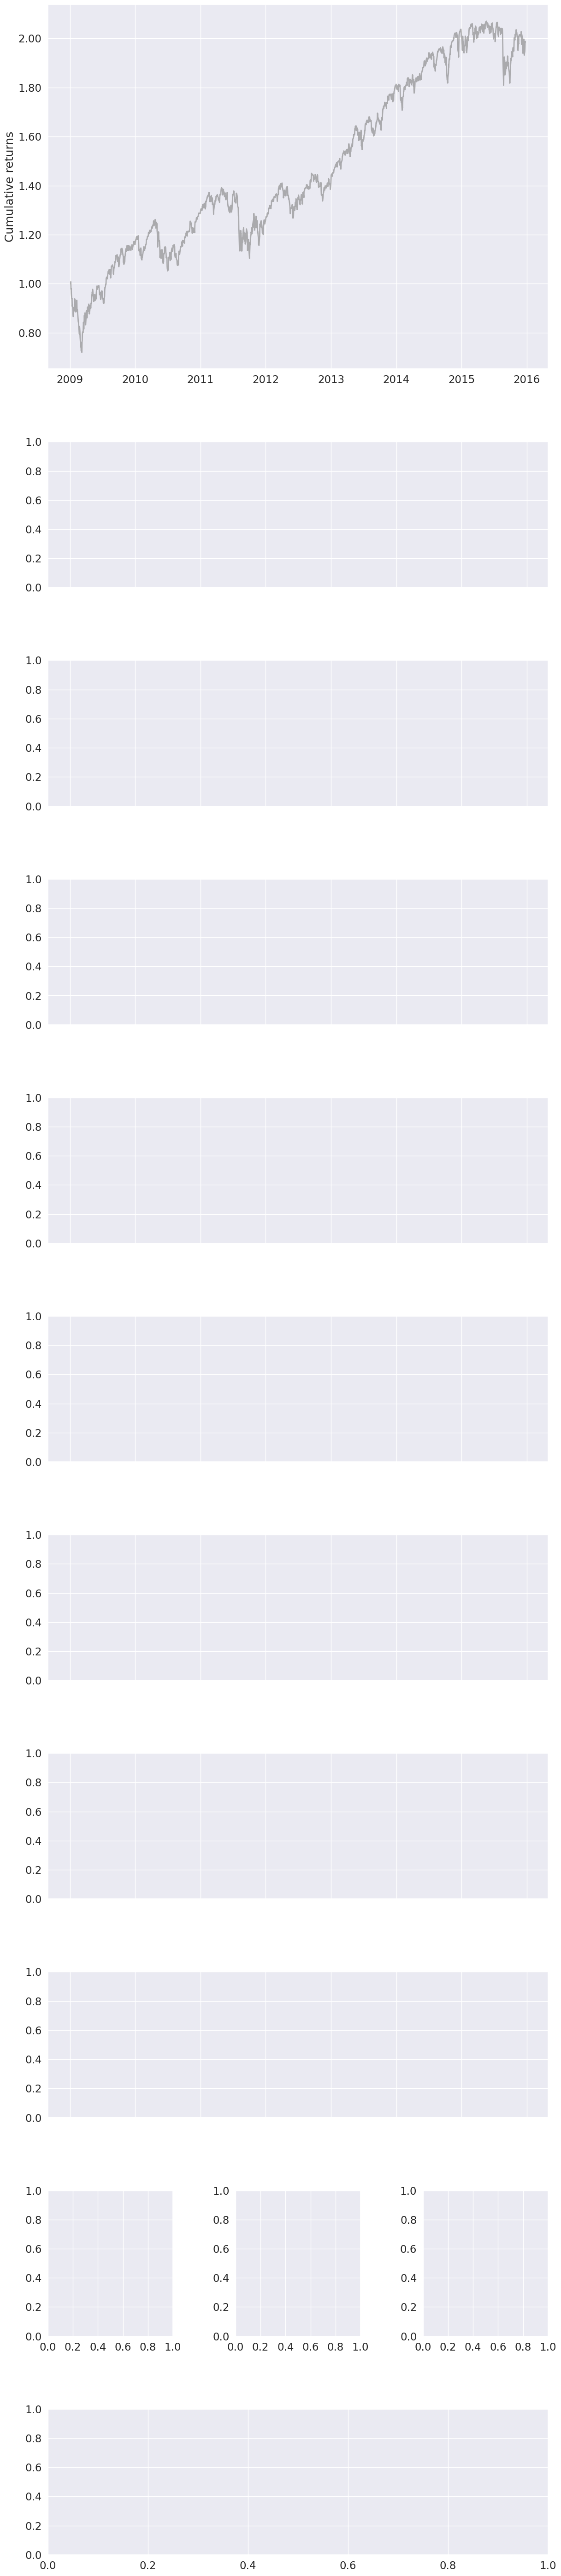

In [32]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)